In [16]:
import pandas as pd
import numpy as np
import py3langid as langid
import string as stringlib
import pickle 
import nltk
from langdetect import detect
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag
from nltk.probability import FreqDist
from recolector import Recolector
import matplotlib.pyplot as plt


In [2]:
# Ya se ejecutó para generar datos_recopilados_p.xlsx

# bot = Recolector(20, 6, 10)
# bot.generar_datos()

df = pd.read_excel('./datos/datos_recopilados_p.xlsx')

In [3]:
"""
        nltk.download("stopwords"): Descarga el dataset de stopwords que vamos a utilizar
        nltk.download("punkt"): Descarga el dataset de signos de puntuacion
        nltk.download("names"): Descarga el dataset de nombres propios
        nltk.download("wordnet"): Descarga una dependencia para el lematizador
        nltk.download("averaged_perceptron_tagger"): Descarga un dataset para las categorias gramaticales
        nltk.download("tagsets"): Descarga otro dataset para categorias gramaticales
"""

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("names")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")
nltk.download("tagsets")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

In [4]:
def game_tokenizer(string):
    string = string.replace("/"," ")
    string = string.replace("-"," ")
    string = string.replace("game","").strip()
    string = word_tokenize(string)

    return string

In [5]:
# De la libreria NLTK guardamos en una variable las stopwrds del idioma ingles
stopwords = nltk.corpus.stopwords.words('english')
# Tambien los nombres proios 
names = nltk.corpus.names.words()
# Aqui se crea una lista de palabra que no queremos, esta contiene nombre de juegos y mas
words_unwanted = ["ds3", "n't","'while", "turn-based", "zelda","game","gameplay","ml",
                  "play", "even", "player", "also", "much", "dont", "cause", "somewhat", "im"]
words_unwanted += str(list(df['Game'].apply(game_tokenizer))).replace("[","").replace("]","").replace("'","").split(",")
words_unwanted = list(set(words_unwanted))
words_unwanted = list(map(lambda x: x.strip(), words_unwanted))

In [6]:
def tokenizer(string):
    """ 
        Entrada: str
        retorna: list

        Tokenizamos la entrada. 
        Gramar servira para seleccionar las palabras que pertenexcan a las categorias gramaticales que deseamos.
        Luego de filtrar cada token, lo pasamos a minuscula y lo lematizamos.
    """
    string = [i for i in string if i not in stringlib.punctuation]
    string = ''.join(string)

    string = word_tokenize(string)
    gramar = ['NN','JJ','VB','RB']
    tokens = []
    selected_tokens = []

    for token in string:
        if token in names or not(token.isalpha()) or token in words_unwanted:
            continue
        token = token.lower()
        if token in stopwords:
            continue
        token = WordNetLemmatizer().lemmatize(token)
        if token in words_unwanted:
            continue
        tokens.append(token)

    tokens = pos_tag(tokens)
    selected_tokens = []

    for i in tokens:
        if i[1] in gramar:
            selected_tokens.append(i[0])
    return selected_tokens

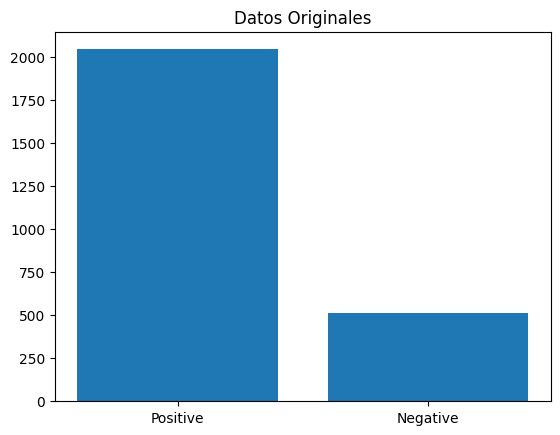

Category
Positive    2042
Negative     512
Name: count, dtype: int64


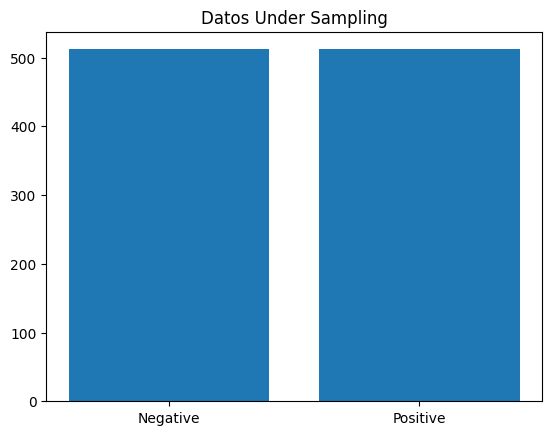

Category
Negative    512
Positive    512
Name: count, dtype: int64


In [34]:
def prepare(df):
    """
    Prepara el dataframe antes de crear el clasificador de texto.

    Args:
        df(pd.DataFrame): Tabla con los comentarios y sus calificaciones.

    Returns:
        df(pd.DataFrame): Tabla preprocesada.

    """

# Filtramos las reviews por idioma, seleccionando solo las que estan en ingles
    df['Language'] = df['Menssage'].apply(lambda x: langid.classify(str(x))[0])
    df = df[df['Language'] == 'en']

# De las dos categorias mas grandes se saca una muestra del tamanio de la categoria mas chica y eliminamos filas nulas
    plt.bar(df['Category'].value_counts().index,df['Category'].value_counts())
    plt.title("Datos Originales")
    plt.show()
    print(df['Category'].value_counts())
    
    distribution_min = df['Category'].value_counts().min()

    df = df.dropna()

# Debe chequearse (under sampling)
    df = pd.concat([
        df[df['Category'] == 'Positive'].sample(distribution_min),
        #df[df['Category'] == 'Mixed'].sample(distribution_min),
        df[df['Category'] == 'Negative'].sample(distribution_min)
    ])
    df = df.reset_index()
    df = df.drop(columns='index')
    

    plt.bar(df['Category'].value_counts().index,df['Category'].value_counts())
    plt.title("Datos Under Sampling")
    plt.show()
    print(df['Category'].value_counts())
    
# Tokenizamos y lematizamos
    df['Menssage'] = df['Menssage'].apply(tokenizer)

# Filtramos los inputs vacios o con un solo token
    df = df[~(df['Menssage'].apply(len) < 2)]

    df['Menssage'] = df['Menssage'].apply(lambda x: ' '.join(x))

    df.reset_index(drop=True)


    return df

df['Category'] = pd.cut(df['Score'], (0,5,10), labels=['Negative','Positive'])
df_p = prepare(df)


In [8]:
vocabulario = {category: [] for category in df['Category'].unique()}

vocabulario_total = []
for _, row in df_p.iterrows():
  tokens = row["Menssage"].split()
  vocabulario[row["Category"]] += tokens  # Se agregan los tokens por categoria
  vocabulario_total += tokens # Se agregan todos los tokens en general

In [9]:
# De aqui sacamos las siguientes palabras: play, even, player, also, much, dont, cause, somewhat, im
most_common_positive = [i[0] for i in FreqDist(vocabulario['Positive']).most_common(500)]
#most_common_mixed = [i[0] for i in FreqDist(vocabulario['Mixed']).most_common(500)]
most_common_negative = [i[0] for i in FreqDist(vocabulario['Negative']).most_common(500)]

#most_common_tokens = list(set(most_common_positive + most_common_mixed + most_common_negative))
most_common_tokens = list(set(most_common_positive + most_common_negative))

In [10]:
# Guardar los tokens
with open("./datos/most_common_positive.tokens", "wb") as file:
  pickle.dump(most_common_positive, file)

# with open("./datos/most_common_mixed.tokens", "wb") as file:
#   pickle.dump(most_common_mixed, file)

with open("./datos/most_common_negative.tokens", "wb") as file:
  pickle.dump(most_common_negative, file)

with open("./datos/most_common_tokens.tokens", "wb") as file:
  pickle.dump(most_common_tokens, file)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report

with open("./datos/most_common_tokens.tokens", "rb") as file:
    vocabulary = pickle.load(file)

vectorizer = TfidfVectorizer(vocabulary=vocabulary)

X = vectorizer.fit_transform(df_p['Menssage'])
y = df_p['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [28]:
models = [GaussianNB(), MultinomialNB(), DecisionTreeClassifier(max_depth=4), RandomForestClassifier()]

for model in models:
    
    model.fit(X_train.toarray(), y_train)

    y_pred = model.predict(X_test.toarray())


    print(f"{model}")
    print(cross_val_score(model,X_train.toarray(), y_train, cv=5, scoring='accuracy').mean(),'\n')
    
    print("Accuracy\n",accuracy_score(y_test, y_pred))
    print("Precision\n", precision_score(y_test, y_pred, average=None) )
    print("Recall\n",recall_score(y_test, y_pred, average=None))
    model.classes_
    print("\n")

0.6989130434782608
GaussianNB()
Accuracy
 0.6881188118811881
Precision
 [0.66666667 0.72368421]
Recall
 [0.8        0.56701031]


0.8046583850931677
MultinomialNB()
Accuracy
 0.7524752475247525
Precision
 [0.73913043 0.77011494]
Recall
 [0.80952381 0.69072165]


0.569611801242236
DecisionTreeClassifier(max_depth=4)
Accuracy
 0.5594059405940595
Precision
 [0.80769231 0.52272727]
Recall
 [0.2        0.94845361]


0.7275776397515529
RandomForestClassifier()
Accuracy
 0.7029702970297029
Precision
 [0.71428571 0.69072165]
Recall
 [0.71428571 0.69072165]




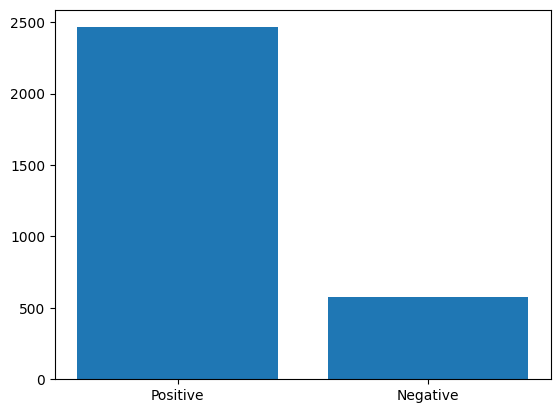

Category
Positive    2464
Negative     574
Name: count, dtype: int64


In [13]:



# Resultado con tres clases

# Accuracy
#  0.6186186186186187
# Precision
#  [0.61538462 0.61904762 0.61971831]
# Recall
#  [0.37037037 0.72222222 0.75213675]

# array(['Mixed', 'Negative', 'Positive'], dtype='<U8')

Accuracy
 0.6881188118811881
Precision
 [0.66666667 0.72368421]
Recall
 [0.8        0.56701031]


array(['Negative', 'Positive'], dtype='<U8')

In [15]:
cm = confusion_matrix(y_pred, y_test)
